# Определение перспективного тарифа для телеком-компании

«Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. 

**Описание данных**

1. Тариф «Смарт»
Ежемесячная плата: 550 рублей
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 3 рубля
сообщение: 3 рубля
1 Гб интернет-трафика: 200 рублей
2. Тариф «Ультра»
Ежемесячная плата: 1950 рублей
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 1 рубль
сообщение: 1 рубль
1 Гб интернет-трафика: 150 рублей

Таблица users (информация о пользователях):


* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана


Таблица calls (информация о звонках):


* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок


Таблица messages (информация о сообщениях):


* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение


Таблица internet (информация об интернет-сессиях):


* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя


Таблица tariffs (информация о тарифах):


* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

**Примечание**


«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.

Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Принимаем, что неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.

**Цель исследования:**

Провести предварительный анализ тарифов на небольшой выборке клиентов.  Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Вопросы:**

1. Расчёт для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя .

2. Описание поведения клиентов оператора, исходя из выборки. 

3. Проверка гипотез:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.


## Изучение данных из файла

### Чтение файла

In [1]:
%autosave 60

Autosaving every 60 seconds


In [2]:
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

In [3]:
users = pd.read_csv('/datasets/users.csv', parse_dates=['churn_date', 'reg_date'])
calls = pd.read_csv('/datasets/calls.csv', parse_dates=['call_date'])
messages = pd.read_csv('/datasets/messages.csv', parse_dates=['message_date'])
internet = pd.read_csv('/datasets/internet.csv', parse_dates=['session_date'])
tariffs = pd.read_csv('/datasets/tariffs.csv')

### Обработка

Рассмотрим таблицы

In [4]:
calls.info()
calls.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


Пропусков нет, тип столбца с датой изменили при чтении, для столбца user_id для экономии памяти меняем:

In [5]:
calls['duration'] = calls['duration'].astype('float32')
calls['user_id'] = calls['user_id'].astype('int32')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float32       
 3   user_id    202607 non-null  int32         
dtypes: datetime64[ns](1), float32(1), int32(1), object(1)
memory usage: 4.6+ MB


Тип данных в столбце duration изменим на int и округлим в большую сторону (согласно условию Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута):

In [6]:
calls['duration'] = np.ceil(calls['duration']).astype('int')
calls.head(10)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000
5,1000_5,2018-11-02,0,1000
6,1000_6,2018-10-18,0,1000
7,1000_7,2018-08-22,19,1000
8,1000_8,2018-09-15,19,1000
9,1000_9,2018-08-15,0,1000


In [8]:
internet.info()
internet.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
107832,107832,1367_7,524.26,2018-09-19,1367
50370,50370,1173_19,174.51,2018-12-08,1173
94157,94157,1318_171,890.72,2018-11-06,1318
132575,132575,1440_267,1273.99,2018-10-14,1440
93700,93700,1317_7,744.66,2018-08-21,1317
43190,43190,1149_190,521.40,2018-10-08,1149
144883,144883,1483_262,429.49,2018-10-12,1483
56010,56010,1187_54,393.64,2018-09-23,1187
8815,8815,1030_284,334.51,2018-06-20,1030
145473,145473,1486_44,302.91,2018-11-28,1486


Пропусков нет, переведем Мб в Гб, округлив в большую сторону (согласно условию -  Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону.)
Добавим результат в новый столбец gb_used. Тип данных в этом столбце изменим на int32:

In [9]:
internet['user_id'] = internet['user_id'].astype('int32')
internet['mb_used'] = internet['mb_used'].astype('int32')
# internet['gb_used'] = (internet['mb_used'] / 1024).apply(np.ceil).astype('int32')
internet['mb_used'] = internet['mb_used'].astype('int32')
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  int32         
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int32         
dtypes: datetime64[ns](1), int32(2), int64(1), object(1)
memory usage: 4.6+ MB


In [10]:
messages.info()
messages.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


,id,message_date,user_id
2371,1005_233,2018-11-21,1005
121695,1492_62,2018-09-13,1492
120390,1487_21,2018-12-03,1487
52032,1231_653,2018-07-20,1231
37814,1165_168,2018-11-17,1165
35498,1151_48,2018-11-21,1151
13799,1057_141,2018-07-10,1057
15942,1067_376,2018-06-24,1067
109420,1440_361,2018-09-03,1440
103219,1421_182,2018-10-07,1421


Пропусков нет, можем только тип столбца user_id поменять на int 32:

In [11]:
messages['user_id'] = messages['user_id'].astype('int32')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int32         
dtypes: datetime64[ns](1), int32(1), object(1)
memory usage: 2.3+ MB


In [12]:
users.info()
users.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
155,1155,71,NaT,Ставрополь,Александр,Чернов,2018-01-02,smart
54,1054,33,NaT,Омск,Кристина,Платонова,2018-03-20,smart
340,1340,50,NaT,Пенза,Тимофей,Алютин,2018-01-30,smart
24,1024,73,NaT,Санкт-Петербург,Иулиан,Антипов,2018-10-31,ultra
311,1311,33,NaT,Тверь,Лолита,Крылова,2018-08-03,smart
87,1087,50,NaT,Санкт-Петербург,Гелена,Абалакова,2018-10-03,smart
146,1146,72,NaT,Санкт-Петербург,Владислав,Никонов,2018-05-25,smart
438,1438,24,2018-12-24,Екатеринбург,Нателла,Бородина,2018-10-05,smart
133,1133,70,NaT,Барнаул,Надежда,Аникина,2018-10-19,smart
263,1263,32,NaT,Балашиха,Ермолай,Зайцев,2018-04-30,smart


пропуски есть в churn_date. Здесь значит, что тариф еще действовал на момент выгрузки данных, оставляем, как есть. Можно изменить тип данных столбцов user_id и age:

In [13]:
users['user_id'] = users['user_id'].astype('int32')
users['age'] = users['age'].astype('int32')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int32         
 1   age         500 non-null    int32         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int32(2), object(4)
memory usage: 27.5+ KB


In [14]:
tariffs.info()
tariffs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Пропусков нет, поменять типы всех столбцов, кроме tariff_name, на int 32:

In [15]:
tariffs['messages_included'] = tariffs['messages_included'].astype('int32')
tariffs['mb_per_month_included'] = tariffs['mb_per_month_included'].astype('int32')
tariffs['minutes_included'] = tariffs['minutes_included'].astype('int32')
tariffs['rub_monthly_fee'] = tariffs['rub_monthly_fee'].astype('int32')
tariffs['rub_per_gb'] = tariffs['rub_per_gb'].astype('int32')
tariffs['rub_per_message'] = tariffs['rub_per_message'].astype('int32')
tariffs['rub_per_minute'] = tariffs['rub_per_minute'].astype('int32')
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int32 
 1   mb_per_month_included  2 non-null      int32 
 2   minutes_included       2 non-null      int32 
 3   rub_monthly_fee        2 non-null      int32 
 4   rub_per_gb             2 non-null      int32 
 5   rub_per_message        2 non-null      int32 
 6   rub_per_minute         2 non-null      int32 
 7   tariff_name            2 non-null      object
dtypes: int32(7), object(1)
memory usage: 200.0+ bytes


Далее по проекту нам необходимо будет сводить таблицы. поэтому сразу можно изменить наименование столбца tariff_name этой таблицы, поскольку в таблице users есть столбец tariff:

In [16]:
tariffs = tariffs.rename(columns = {'tariff_name':'tariff'})
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Добавляем столбец gb_per_month_included, чтобы далее работать в Гб, а также округляем в большую сторону, как ранее, согласно условию:

In [17]:
tariffs['gb_per_month_included'] = (tariffs['mb_per_month_included'] / 1024).astype('int')
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff,gb_per_month_included
0,50,15360,500,550,200,3,3,smart,15
1,1000,30720,3000,1950,150,1,1,ultra,30


### Вывод

Рассмотрели таблицы с данными о пользователях, с информацией об использованных звонках, сообщениях, Интернете, со сведениями о тарифах.

Серьезных ошибок не найдено.

- поправили тип данных, 
- переименовали столбец в таблице с тарифами для облегчения дальнейшей работы со сводными таблицами,
- округлили значения потраченных минут (в соответствии с условием)


## Добавление дополнительных сведений

### Количество сделанных звонков и израсходованных минут разговора по месяцам

Добавим столбец 'month':

In [18]:
calls['month'] = calls['call_date'].dt.month
calls.info()
calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int64         
 3   user_id    202607 non-null  int32         
 4   month      202607 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(2), object(1)
memory usage: 7.0+ MB


,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12


Посчитаем кол-во израсходованных минут и кол-во сделанных звонков по месяцам:

In [19]:
calls_grouped_by_months = calls.groupby(['user_id', 'month']).agg({'duration':'sum','id':'count'}).reset_index()
calls_grouped_by_months.head()

,user_id,month,duration,id
0,1000,5,159,22
1,1000,6,172,43
2,1000,7,340,47
3,1000,8,408,52
4,1000,9,466,58


### Количество отправленных сообщений по месяцам

Добавим столбец 'month':

In [20]:
messages['month'] = messages['message_date'].dt.month
messages.info()
messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int32         
 3   month         123036 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(1), object(1)
memory usage: 3.3+ MB


,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


Посчитаем кол-во отправленных сообщений по месяцам:

In [21]:
messages_grouped_by_months = messages.groupby(['user_id', 'month']).agg({'id':'count'}).reset_index()
messages_grouped_by_months.head()

,user_id,month,id
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


### Объем израсходованного интернет-трафика по месяцам

Добавим столбец 'month':

In [22]:
internet['month'] = internet['session_date'].dt.month
internet.info()
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  int32         
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int32         
 5   month         149396 non-null  int64         
dtypes: datetime64[ns](1), int32(2), int64(2), object(1)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id,month
0,0,1000_0,112,2018-11-25,1000,11
1,1,1000_1,1052,2018-09-07,1000,9
2,2,1000_2,1197,2018-06-25,1000,6
3,3,1000_3,550,2018-08-22,1000,8
4,4,1000_4,302,2018-09-24,1000,9


Посчитаем объем израсходованного Интернета по месяцам. 

In [23]:
internet_grouped_by_months = internet.groupby(['user_id', 'month']).agg({'mb_used':'sum'}).reset_index()
internet_grouped_by_months['gb_used'] = (internet_grouped_by_months['mb_used'] / 1024).apply(np.ceil).astype('int32')
internet_grouped_by_months.head()

,user_id,month,mb_used,gb_used
0,1000,5,2252,3
1,1000,6,23213,23
2,1000,7,13988,14
3,1000,8,14043,14
4,1000,9,14556,15


### Помесячная выручка с каждого пользователя 

Объединим созданные сводные таблицы messages_grouped_by_months, calls_grouped_by_months, internet_grouped_by_months:

In [24]:
user_summary_table = calls_grouped_by_months.merge(messages_grouped_by_months, on=['user_id', 'month'], how='outer') \
                           .merge(internet_grouped_by_months, on=['user_id', 'month'], how='outer')
user_summary_table = user_summary_table.rename(columns={'duration':'minutes_used', 'id_x':'calls_count', 'id_y':'sms_count'})
user_summary_table.head()

,user_id,month,minutes_used,calls_count,sms_count,mb_used,gb_used
0,1000,5,159.0,22.0,22.0,2252.0,3.0
1,1000,6,172.0,43.0,60.0,23213.0,23.0
2,1000,7,340.0,47.0,75.0,13988.0,14.0
3,1000,8,408.0,52.0,81.0,14043.0,14.0
4,1000,9,466.0,58.0,57.0,14556.0,15.0


Добавляем информацию о пользователях users:

In [25]:
user_summary_table = user_summary_table.merge(users, on='user_id', how='left')
user_summary_table.head()

,user_id,month,minutes_used,calls_count,sms_count,mb_used,gb_used,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,159.0,22.0,22.0,2252.0,3.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,172.0,43.0,60.0,23213.0,23.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,340.0,47.0,75.0,13988.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,408.0,52.0,81.0,14043.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,466.0,58.0,57.0,14556.0,15.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


Добавляем информацию о тарифах tariffs:

In [26]:
user_summary_table = user_summary_table.merge(tariffs, on='tariff', how='left')
user_summary_table.head()

,user_id,month,minutes_used,calls_count,sms_count,mb_used,gb_used,age,churn_date,city,...,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included
0,1000,5,159.0,22.0,22.0,2252.0,3.0,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30
1,1000,6,172.0,43.0,60.0,23213.0,23.0,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30
2,1000,7,340.0,47.0,75.0,13988.0,14.0,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30
3,1000,8,408.0,52.0,81.0,14043.0,14.0,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30
4,1000,9,466.0,58.0,57.0,14556.0,15.0,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30


In [27]:
user_summary_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3214 non-null   int64         
 1   month                  3214 non-null   int64         
 2   minutes_used           3174 non-null   float64       
 3   calls_count            3174 non-null   float64       
 4   sms_count              2717 non-null   float64       
 5   mb_used                3203 non-null   float64       
 6   gb_used                3203 non-null   float64       
 7   age                    3214 non-null   int32         
 8   churn_date             187 non-null    datetime64[ns]
 9   city                   3214 non-null   object        
 10  first_name             3214 non-null   object        
 11  last_name              3214 non-null   object        
 12  reg_date               3214 non-null   datetime64[ns]
 13  tar

Видим, что в итоговой таблице есть пропуски в столбцах minutes_used, calls_count, sms_count, gb_used. Это значит, пользователь мог пользоваться Интернетом, но не пользовался смс, например. Поэтому можем эти пропуски заменить на 0: 

In [28]:
user_summary_table.fillna({'minutes_used': 0,
                  'calls_count': 0,
                  'sms_count': 0,
                  'gb_used': 0}, 
                 inplace=True)
user_summary_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3214 non-null   int64         
 1   month                  3214 non-null   int64         
 2   minutes_used           3214 non-null   float64       
 3   calls_count            3214 non-null   float64       
 4   sms_count              3214 non-null   float64       
 5   mb_used                3203 non-null   float64       
 6   gb_used                3214 non-null   float64       
 7   age                    3214 non-null   int32         
 8   churn_date             187 non-null    datetime64[ns]
 9   city                   3214 non-null   object        
 10  first_name             3214 non-null   object        
 11  last_name              3214 non-null   object        
 12  reg_date               3214 non-null   datetime64[ns]
 13  tar

Расчет выручки:

- вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; 
- остаток умножьте на значение из тарифного плана; 
- прибавьте абонентскую плату, соответствующую тарифному плану

In [29]:
# плата за минуты, изначально принимаем равной нулю
bill_minutes = 0 
# плата за смс, изначально принимаем равной нулю
bill_sms = 0
#плата за Гб, изначально принимаем равной нулю
bill_gb = 0

def to_count_revenue(row):
    minutes_used = row['minutes_used'] 
    minutes_included = row['minutes_included']
    sms_count = row['sms_count']
    messages_included = row['messages_included']
    gb_used = row['gb_used']
    gb_per_month_included = row['gb_per_month_included']
    rub_per_minute = row['rub_per_minute']
    rub_per_message = row['rub_per_message']
    rub_per_gb = row['rub_per_gb']
    rub_monthly_fee = row['rub_monthly_fee']
    if minutes_used > minutes_included: 
        # вычисление доплаты в случае, если израсходованное больше, чем лимит по тарифу
        bill_minutes = (minutes_used - minutes_included)* rub_per_minute
        # в ином случае - израсходованное не превышает лимита по тарифу
    else:
        bill_minutes = 0
    if sms_count > messages_included: 
        bill_sms = (sms_count - messages_included)* rub_per_message
    else:
        bill_sms = 0
    if gb_used > gb_per_month_included: 
        bill_gb = (gb_used - gb_per_month_included)* rub_per_gb
    else:
        bill_gb = 0
    # Возвращаем сумму доплат за превышение лимита (если оно имеется) и абонентской платы по тарифу
    return bill_minutes + bill_sms + bill_gb + rub_monthly_fee 

In [30]:
# создание нового столбца с выручкой по расчету выше
user_summary_table['revenue'] = user_summary_table.apply(to_count_revenue, axis=1)
user_summary_table.head()

,user_id,month,minutes_used,calls_count,sms_count,mb_used,gb_used,age,churn_date,city,...,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,revenue
0,1000,5,159.0,22.0,22.0,2252.0,3.0,52,NaT,Краснодар,...,ultra,1000,30720,3000,1950,150,1,1,30,1950.0
1,1000,6,172.0,43.0,60.0,23213.0,23.0,52,NaT,Краснодар,...,ultra,1000,30720,3000,1950,150,1,1,30,1950.0
2,1000,7,340.0,47.0,75.0,13988.0,14.0,52,NaT,Краснодар,...,ultra,1000,30720,3000,1950,150,1,1,30,1950.0
3,1000,8,408.0,52.0,81.0,14043.0,14.0,52,NaT,Краснодар,...,ultra,1000,30720,3000,1950,150,1,1,30,1950.0
4,1000,9,466.0,58.0,57.0,14556.0,15.0,52,NaT,Краснодар,...,ultra,1000,30720,3000,1950,150,1,1,30,1950.0


### Вывод

Рассчитали дополнительные данные по каждому пользователю, разбили расходы по месяцам, посчитали выручку

## Анализ данных

In [31]:
# Разделим пользователей на отдельные датафреймы по тарифам
smart = user_summary_table[user_summary_table['tariff'] == 'smart']
ultra = user_summary_table[user_summary_table['tariff'] == 'ultra']

### Анализ израсходованных минут

In [32]:
# выведем среднее, дисперсию и стандартное отклонение в общем по каждому тарифу, а также минимум и максимум
user_summary_table.groupby('tariff').agg({'minutes_used': ['mean', 'var', 'std', 'max', 'min']}).round(2)         

minutes_used                                
               mean        var     std     max  min
tariff                                             
smart        417.93   36219.32  190.31  1435.0  0.0
ultra        526.62  100873.63  317.61  1673.0  0.0

In [33]:
# выведем среднее, дисперсию и стандартное отклонение, а также минимум и максимум по месяцам по каждому тарифу
user_summary_table.groupby(['tariff', 'month']).agg({'minutes_used': ['mean', 'var', 'std', 'max', 'min']}).round(2).T 

tariff                smart                                                    \
month                    1         2         3         4         5         6    
minutes_used mean    203.85    298.69    390.05    367.13    387.36    395.64   
             var   23787.34  36412.29  36823.16  34778.21  34820.06  30742.92   
             std     154.23    190.82    191.89    186.49    186.60    175.34   
             max     551.00    747.00    822.00    785.00    820.00    875.00   
             min       0.00      2.00     13.00      0.00      2.00      0.00   

tariff                                                     ...      ultra  \
month                    7         8         9         10  ...         3    
minutes_used mean    408.35    421.47    428.61    426.14  ...     489.65   
             var   32250.27  34793.58  33535.34  35392.34  ...  111384.90   
             std     179.58    186.53    183.13    188.13  ...     333.74   
             max     839.00   1000.00    843.00   1005.00  ...    1609.00   
             min       2.00      0.00      0.00      0.00  ...      92.00   

tariff                                                               \
month                    4         5         6         7         8    
minutes_used mean    458.02    510.33    479.70    545.79    510.78   
             var   71653.87  83870.19  91535.95  94322.28  97956.50   
             std     267.68    289.60    302.55    307.12    312.98   
             max    1096.00   1232.00   1410.00   1311.00   1321.00   
             min       0.00      0.00      0.00      0.00      0.00   

tariff                                                        
month                     9          10        11         12  
minutes_used mean     539.44     558.08    541.38     592.81  
             var   105716.78  106464.58  96570.06  117276.33  
             std      325.14     326.29    310.76     342.46  
             max     1297.00    1401.00   1257.00    1673.00  
             min        0.00       0.00      0.00       0.00  

[5 rows x 24 columns]

Построим гистограммы для тарифов:

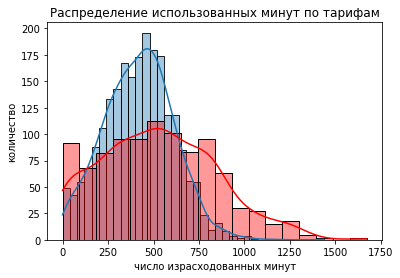

In [63]:
sns.histplot(x=smart['minutes_used'], kde=True, alpha=0.4).set_title("Распределение использованных минут по тарифам")
sns.histplot(x=ultra['minutes_used'], kde=True, color='r', alpha=0.4)
plt.xlabel('число израсходованных минут')
plt.ylabel('количество')
plt.show()

#### Выводы:

- Для обоих тарифов вышло нормальное распределение по данному критерию
- Количество израсходованных минут для пользователей обоих тарифов примерно на одном уровне, но в случае с тарифом smart -это близко к их лимиту, а для ultra - это гораздо ниже порога (500 минут и 3000 минут)

### Анализ израсходованных смс

In [351]:
# выведем среднее, дисперсию и стандартное отклонение в общем по каждому тарифу , а также минимум и максимум
user_summary_table.groupby('tariff').agg({'sms_count': ['mean', 'var', 'std', 'max', 'min']}).round(2)

sms_count                            
            mean      var    std    max  min
tariff                                      
smart      33.38   796.81  28.23  143.0  0.0
ultra      49.36  2285.27  47.80  224.0  0.0

In [352]:
# выведем среднее, дисперсию и стандартное отклонение по месяцам по каждому тарифу, а также минимум и максимум
user_summary_table.groupby(['tariff', 'month']).agg({'sms_count': ['mean', 'var', 'std', 'max', 'min']}).round(2).T

tariff           smart                                                  \
month               1       2       3       4       5       6       7    
sms_count mean   18.24   24.09   31.86   30.74   33.77   33.40   33.75   
          var   262.37  473.10  718.49  602.14  730.99  806.81  799.89   
          std    16.20   21.75   26.80   24.54   27.04   28.40   28.28   
          max    74.00   85.00  110.00  105.00  103.00  134.00  137.00   
          min     0.00    0.00    0.00    0.00    0.00    0.00    0.00   

tariff                                  ...    ultra                    \
month               8       9       10  ...       3        4        5    
sms_count mean   33.64   33.64   33.77  ...    32.30    31.56    37.85   
          var   838.26  790.62  816.11  ...  1732.38  1407.29  1624.64   
          std    28.95   28.12   28.57  ...    41.62    37.51    40.31   
          max   134.00  136.00  139.00  ...   155.00   143.00   148.00   
          min     0.00    0.00    0.00  ...     0.00     0.00     0.00   

tariff                                                                         
month                6        7        8        9        10       11       12  
sms_count mean    41.73    49.85    48.44    52.29    58.43    55.79    60.61  
          var   1986.30  2372.04  2171.74  2152.86  2697.18  2476.95  2681.98  
          std     44.57    48.70    46.60    46.40    51.93    49.77    51.79  
          max    201.00   211.00   180.00   188.00   223.00   197.00   224.00  
          min      0.00     0.00     0.00     0.00     0.00     0.00     0.00  

[5 rows x 24 columns]

Построим гистограммы для тарифов:

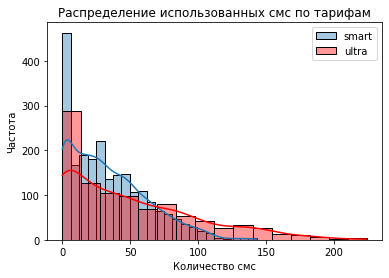

In [353]:
sns.histplot(x=smart['sms_count'], kde=True, alpha=0.4, label='smart').set_title("Распределение использованных смс по тарифам")
sns.histplot(x=ultra['sms_count'], kde=True, color='r', alpha=0.4, label='ultra')
plt.xlabel('Количество смс')
plt.ylabel('Частота')
plt.legend()
plt.show()

#### Выводы:

- Среди пользователей обоих тарифов не популярны смс, они не превышают лимит

### Анализ израсходованного Интернет-трафика

In [356]:
# выведем среднее, дисперсию и стандартное отклонение в общем по каждому тарифу, а также минимум и максимум
user_summary_table.groupby('tariff').agg({'gb_used': ['mean', 'var', 'std', 'max', 'min']}).round(2)

gb_used                        
          mean    var   std   max  min
tariff                                
smart    16.31  32.93  5.74  38.0  0.0
ultra    19.48  96.97  9.85  49.0  0.0

In [357]:
# выведем среднее, дисперсию и стандартное отклонение по месяцам по каждому тарифу, а также минимум и максимум
user_summary_table.groupby(['tariff', 'month']).agg({'gb_used': ['mean', 'var', 'std', 'max', 'min']}).round(2).T

tariff        smart                                                          \
month            1      2      3      4      5      6      7      8      9    
gb_used mean   8.74  11.84  15.22  13.61  15.89  15.94  15.84  16.70  16.38   
        var   39.41  37.15  32.41  31.16  34.20  31.95  33.24  30.06  25.80   
        std    6.28   6.10   5.69   5.58   5.85   5.65   5.77   5.48   5.08   
        max   24.00  28.00  25.00  27.00  29.00  34.00  29.00  31.00  31.00   
        min    1.00   1.00   2.00   1.00   1.00   1.00   1.00   0.00   1.00   

tariff               ...   ultra                                             \
month            10  ...      3      4      5      6      7       8      9    
gb_used mean  16.85  ...   17.59  16.93  19.37  18.94  20.49   19.59  19.23   
        var   32.75  ...  113.97  89.62  95.63  82.39  96.01  104.89  85.95   
        std    5.72  ...   10.68   9.47   9.78   9.08   9.80   10.24   9.27   
        max   32.00  ...   37.00  37.00  43.00  42.00  45.00   48.00  42.00   
        min    0.00  ...    3.00   1.00   0.00   0.00   0.00    0.00   0.00   

tariff                              
month            10     11      12  
gb_used mean  20.06  19.80   21.71  
        var   91.28  93.52  103.39  
        std    9.55   9.67   10.17  
        max   49.00  44.00   43.00  
        min    0.00   0.00    0.00  

[5 rows x 24 columns]

Построим распределения для тарифов:

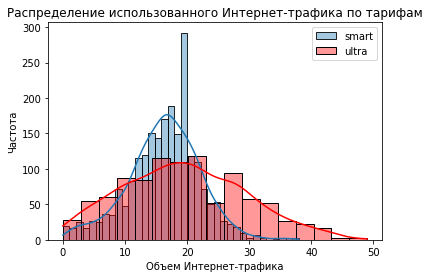

In [358]:
sns.histplot(x=smart['gb_used'], kde=True, alpha=0.4, label='smart').set_title("Распределение использованного Интернет-трафика по тарифам")
sns.histplot(x=ultra['gb_used'], kde=True, color='r', alpha=0.4, label='ultra')
plt.xlabel('Объем Интернет-трафика')
plt.ylabel('Частота')
plt.legend()
plt.show()

#### Вывод

- Средний расход Интернет-трафика примерно одинаков для пользователей обоих тарифов
- В среднем пользователи smart чаще превышают свой лимит

### Анализ выручки

In [361]:
# выведем среднее, дисперсию и стандартное отклонение в общем по каждому тарифу, а также минимум и максимум
user_summary_table.groupby('tariff').agg({'revenue': ['mean', 'var', 'std', 'max', 'min']}).round(2)

revenue                                   
           mean        var     std     max     min
tariff                                            
smart   1286.56  666709.80  816.52  6770.0   550.0
ultra   2069.54  140382.41  374.68  4800.0  1950.0

In [362]:
# выведем среднее, дисперсию и стандартное отклонение по месяцам по каждому тарифу, а также минимум и максимум
user_summary_table.groupby(['tariff', 'month']).agg({'revenue': ['mean', 'var', 'std', 'max', 'min']}).round(2).T

tariff            smart                                              \
month                1          2          3          4          5    
revenue mean     721.32     827.60    1162.03     959.52    1196.09   
        var   192516.16  292358.66  484677.58  313180.00  516252.47   
        std      438.77     540.70     696.19     559.62     718.51   
        max     2350.00    3432.00    2721.00    2950.00    3375.00   
        min      550.00     550.00     550.00     550.00     550.00   

tariff                                                               ...  \
month                6          7          8          9          10  ...   
revenue mean    1202.80    1217.98    1315.49    1247.64    1359.41  ...   
        var   555669.73  539197.83  623453.99  534109.92  708311.53  ...   
        std      745.43     734.30     789.59     730.83     841.61  ...   
        max     4473.00    3350.00    4427.00    3759.00    4231.00  ...   
        min      550.00     550.00     550.00     550.00     550.00  ...   

tariff           ultra                                                       \
month               3         4          5         6          7          8    
revenue mean   2014.86   2001.82    2059.70   2039.29    2116.48    2081.78   
        var   43175.68  38515.15  162669.61  99823.58  194725.27  158650.59   
        std     207.79    196.25     403.32    315.95     441.28     398.31   
        max    3000.00   3000.00    3900.00   3750.00    4200.00    4650.00   
        min    1950.00   1950.00    1950.00   1950.00    1950.00    1950.00   

tariff                                                   
month               9          10         11         12  
revenue mean   2023.04    2065.85    2091.04    2138.85  
        var   58565.22  149685.13  165031.98  232610.26  
        std     242.00     386.89     406.24     482.30  
        max    3750.00    4800.00    4050.00    3900.00  
        min    1950.00    1950.00    1950.00    1950.00  

[5 rows x 24 columns]

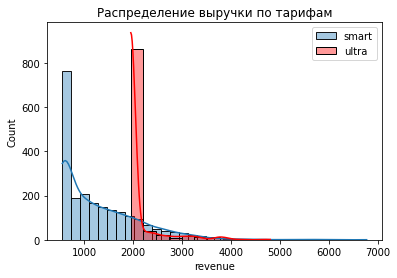

In [363]:
sns.histplot(x=smart['revenue'], kde=True, alpha=0.4, label='smart').set_title("Распределение выручки по тарифам")
sns.histplot(x=ultra['revenue'], kde=True, color='r', alpha=0.4, label='ultra')
plt.legend()
plt.show()

#### Вывод

В среднем пользователи тарифа smart переплачивают почти в 2 раза, в отличие от пользователей ultra - у них переплаты есть, но не такие внушительные.

### Вывод

- Среди пользователей обоих тарифов смс - необязательный критерий, они практически не пользуются ими
- Пользователи smart в среднем на пределе используют кол-во минут, включенных в тарифный план, пользователи ultra наоборот - при том, что и те, и те тратят примерно одинаково, последние в среднем используют только 1/6 своего лимита
- Среднее значение использованного объема Интернет-трафика чуть больше у пользователей ultra, при этом , выходит, что они не превышают свой лимит, а у пользователей smart чаще случаются переплаты

## Проверка гипотез

### Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

**Введем нулевую и альтернативные гипотезы**:


   H0 : Средние выручки тарифов «Ультра» и «Смарт» одинаковы
   
   H1 : Средние выручки тарифов «Ультра» и «Смарт» различны
   
 Уровень значимости: alpha = 0.05
 
 Рассчитаем p-value:
 - При p-value меньше выбранного уровня значимости будут основания отвергнуть нулевую гипотезу о равенстве средних выручек тарифов в пользу альтернативной. 
 - Иначе - сделаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

In [364]:
alpha = .05
results = stats.ttest_ind(smart['revenue'], ultra['revenue'], equal_var=False)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print('Имеются основания исключить нулевую гипотезу')
else:
    print('Нельзя отвергнуть нулевую гипотезу')

p-значение: 8.40789217310225e-253
Имеются основания исключить нулевую гипотезу


#### Вывод

- На доступных данных на 5% уровне значимости имеются основания отвергнуть нулевую гипотезу в пользу альтернативной.

### Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [365]:
# оформим таблицу, основываясь на местоположении пользователя (Москва - другие регионы)
user_summary_table['region'] = np.where(user_summary_table['city'] == 'Москва', 'Москва', 'Другие регионы')
# отдельно выделим Москву и отдельно другие регионы
moscow = user_summary_table[user_summary_table['region'] == 'Москва']
regions = user_summary_table[user_summary_table['region'] == 'Другие регионы']

**Введем нулевую и альтернативные гипотезы**:


   H0 : Cредняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов
   
   H1 : Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов
   
 Уровень значимости: alpha = 0.05
 
 Рассчитаем p-value:
 - При p-value меньше выбранного уровня значимости будут основания отвергнуть нулевую гипотезу о равенстве средних выручек пользователей из Москвы и из других регионов в пользу альтернативной. 
 - Иначе - сделаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

In [366]:
alpha = .05
results = stats.ttest_ind(moscow['revenue'], regions['revenue'], equal_var=False)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print('Имеются основания отвергнуть нулевую гипотезу')
else:
    print('Недостаточно оснований, чтобы отвергнуть нулевую гипотезу')

p-значение: 0.517656692853026
Недостаточно оснований, чтобы отвергнуть нулевую гипотезу


#### Вывод

- На доступных данных на 5% уровне значимости недостаточно оснований, чтобы отвергнуть нулевую гипотезу в пользу альтернативной.
- Средние выручки пользователей из Москвы и пользователей из других регионов одинаковы.

## Общий вывод

- Провели предобработку данных
- Расчитали дополнительно расход Интернета, смс и звонков по месяцам для обоих тарифов
- Расчитали среднюю выручку для обоих тарифов
- Проанализировали статистику на основе статистических параметров и гистограмм
- Провели проверку гипотез:
1. Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов
2. Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различаются


**Общие выводы на основе представленных данных**:
- Наиболее популярным среди пользователей является использование Интернета, в обоих тарифах происходит сильное превышение, соответственно, но **высокие** переплаты именно у smart, несмотря на это в среднем даже со значительным привышением (почти в два раза) , выходит, дешевле, чем ultra

**Рекомендации компании**:
- Если выбирать из данных тарифов, то для пользователя скорее будет выгодно использовать smart, т.к. абонентская плата ultra высока, но со временем есть вероятность, что пользователи smart уйдут, т.к. им явно не будет хватать услуг Интернета, а с этим и ожидают большие переплаты
- Возможно, необходимо предусмотреть, что есть большое количество пользователей, заинтересованных в большом объеме Интернет-трафика (намного превышающего лимит по обоим представленным тарифам), представить предложение для них. 
- т.к. оказывается, что выручка в Москве и др. регионах одинакова, компании следует рекламировать свои услуги по разным региональным направлениям в равной степени.